In [231]:
using Catalyst, Symbolics, Plots, DifferentialEquations
include("../src/SynthEvo.jl")
C = SynthEvo.make_FullyConnectedNonExplosive_CRN(3)
println("done")

x = nothing
input = 1
u0 = [0. for _ in 1:243]
control0 = [input]
p0 = [1. for i in 1:80]
t0 = 10.
t1 = 20.
perturbation_list = [i+1 for i in 1:12]
#perturbation_list = [0.2, 0.5, 0.8, 1.2, 1.5, 1.8]

base_problem_ext = SynthEvo.make_base_problem(C, C.ext_ode, u0, control0, p0, t0, true, 0.1)
base_problem_ode = SynthEvo.make_base_problem(C, C.ode, u0[1:3], control0, p0, t0, true, 0.1)

# loss1 = SynthEvo.adaptation_loss(C, 2, 3, 10., 20.)
# loss2 = SynthEvo.sensitivity_loss(C, 2, 3, 0.25, 10., 10.5)
# loss3 = SynthEvo.steady_state_loss(C, 2, 10., 20., 6, 16.)
# loss4 = SynthEvo.regularization_loss(C, 1)
# l = SynthEvo.weighted_loss([loss1, loss2, loss3, loss4], [10,10,100,0.1])

loss1 = SynthEvo.ultrasensitivity_loss(C, 1, t1, 3, 4, input, 0.75, 0.25)
loss2 = SynthEvo.steady_state_loss(C, 2, t0, t1, t0-4, t1-4)
loss3 = SynthEvo.regularization_loss(C, 1)
l = SynthEvo.weighted_loss([loss1, loss2, loss3], [10, 100, 0.01])

gd_options = (
    n_iter = 100,
    verbose = false,
    use_random_perturbation = false, # TODO maybe move to perturbation_options
    use_pruning_heuristic = false,
    clip_value = nothing,
    use_gradient_normalization = false,
    use_gradient_noise = false,
    alpha = 0.01,
    use_adam = false,
    ADAM_beta1 = 0.9,
    ADAM_beta2 = 0.9,
    use_adagrad = true
)

gd_perturbation_options = (
    t0 = t0,
    t1 = t1,
    loss_fun = l,
    input = input,
    perturbation_list = [i+1 for i in 1:12]
)

ga_options = (
    genetic_pool_size = 100,
    elite = 10,
    worst = 20,
    death_rate = 0.05,
    mutation_rate = 0.30,
    gradient_mutation_rate = 0.01,
    duplication_rate = 0.20,
    crossover_rate = 0.,
    max_generations = 100,
    p_cross = 0.1,
    dp = 0.05,
)

ga_options_NFB = (
    genetic_pool_size = 100,
    elite = 0,
    worst = 0,
    death_rate = (rank) -> 0.0*(rank),
    mutation_rate = (rank) -> 0.50,
    gradient_mutation_rate = (rank) -> 0.02*(1-rank),
    duplication_rate = (rank) -> 0.0*(1-rank),
    crossover_rate = (rank) -> 0.0*(1-rank),
    max_generations = 100,
    p_cross = 0.1,
    dp = 0.05,
)

ga_perturbation_options = (
    use_random_perturbation = false,
    t0 = t0,
    t1 = t1,
    loss_fun = l,
    input = input,
    perturbation_list = [i+1 for i in 1:12]
)

mutate_with_GD = (p) -> SynthEvo.symbolic_gradient_descent(p, C, gd_options, gd_perturbation_options).parameters

ga_loss = SynthEvo.prepare_GA_loss(C, base_problem_ode, ga_perturbation_options)

print("setup done!")

done


setup done!

In [192]:
# initialize the state
state = SynthEvo.initialize_state(C.number_of_parameters, ga_options)
print("done")

done

In [193]:
@time out = SynthEvo.runp_SF_CPU(C, base_problem_ode, state.pool, ga_perturbation_options.t0, ga_perturbation_options.t1, perturbation_list)
nothing

  0.484756 seconds (313.10 k allocations: 40.730 MiB, 172.32% compilation time)


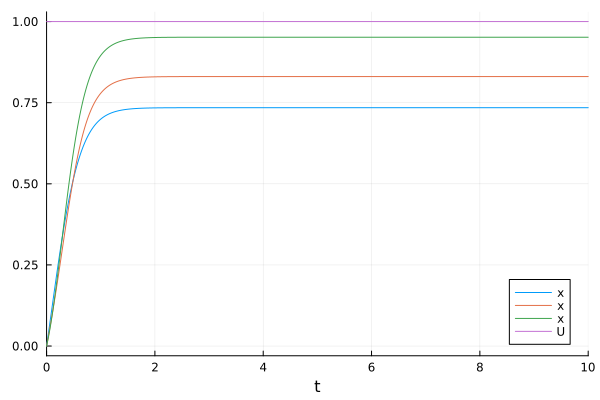

In [194]:
plot(out[1][1])

In [195]:
@time out = ga_loss(state)
nothing

  1.655821 seconds (1.69 M allocations: 127.120 MiB, 458.75% compilation time)


In [196]:
l

(fun = Main.SynthEvo.var"#103#104"(), fun_dx = Function[Main.SynthEvo.var"#105#106"(), Main.SynthEvo.var"#107#108"(), Main.SynthEvo.var"#109#110"(), Main.SynthEvo.var"#111#112"(), Main.SynthEvo.var"#113#114"()], expr = 0.01(abs(k[52]) + abs(k[31]) + abs(k[78]) + abs(k[17]) + abs(k[25]) + abs(k[61]) + abs(k[34]) + abs(k[73]) + abs(k[40]) + abs(k[76]) + abs(k[59]) + abs(k[11]) + abs(k[57]) + abs(k[26]) + abs(k[54]) + abs(k[27]) + abs(k[67]) + abs(k[13]) + abs(k[15]) + abs(k[62]) + abs(k[32]) + abs(k[39]) + abs(k[70]) + abs(k[23]) + abs(k[18]) + abs(k[50]) + abs(k[29]) + abs(k[48]) + abs(k[43]) + abs(k[42]) + abs(k[22]) + abs(k[9]) + abs(k[38]) + abs(k[63]) + abs(k[20]) + abs(k[8]) + abs(k[41]) + abs(k[14]) + abs(k[68]) + abs(k[53]) + abs(k[7]) + abs(k[64]) + abs(k[6]) + abs(k[60]) + abs(k[69]) + abs(k[33]) + abs(k[37]) + abs(k[44]) + abs(k[10]) + abs(k[24]) + abs(k[4]) + abs(k[46]) + abs(k[16]) + abs(k[5]) + abs(k[80]) + abs(k[71]) + abs(k[75]) + abs(k[12]) + abs(k[74]) + abs(k[72]) + ab

In [232]:
using ProgressBars
max_generations = ga_options.max_generations
iter = ProgressBar(1:max_generations)
for i in iter
    state = SynthEvo.symbolic_evolve(ga_loss, state, mutate_with_GD, ga_options)
    set_postfix(iter, avg_loss=state.history.mean_loss[end], best_loss=state.history.best_loss[end])
end

# using ProgressBars
# max_generations = ga_options.max_generations
# output_degradation_parameter = 29
# for i in ProgressBar(1:max_generations)
#     state = SynthEvo.symbolic_evolve_NFB(ga_loss, state, mutate_with_GD, ga_options_NFB, output_degradation_parameter, 0.1)
# end

0.0%┣                                              ┫ 0/100 [00:00<00:-2, -0s/it]
1.0%┣┫ 1/100 [00:05<Inf:Inf, InfGs/it, avg_loss: 4.345423652954148, best_loss: 1.0168702924665054]
2.0%┣┫ 2/100 [00:08<12:58, 8s/it, avg_loss: 4.248365458220289, best_loss: 1.0168702924665054]
3.0%┣┫ 3/100 [00:08<06:38, 4s/it, avg_loss: 4.278857163070868, best_loss: 1.0168702924665054]
4.0%┣┫ 4/100 [00:12<06:30, 4s/it, avg_loss: 4.375448955467906, best_loss: 1.0168702924665054]
5.0%┣┫ 5/100 [00:16<06:21, 4s/it, avg_loss: 4.316507841765627, best_loss: 1.0168702924665054]
6.0%┣┫ 6/100 [00:16<05:05, 3s/it, avg_loss: 4.4105536919930275, best_loss: 1.0168702924665054]
7.0%┣┫ 7/100 [00:19<05:00, 3s/it, avg_loss: 4.388314986759731, best_loss: 1.0168702924665054]
8.0%┣┫ 8/100 [00:23<05:02, 3s/it, avg_loss: 4.316076223489133, best_loss: 1.0168702924665054]
9.0%┣┫ 9/100 [00:26<04:56, 3s/it, avg_loss: 4.34167809018757, best_loss: 1.0168702924665054]
10.0%┣┫ 10/100 [00:32<05:16, 4s/it, avg_loss: 4.210044508603532, bes

InterruptException: InterruptException:

# OLDER STUFF

In [198]:
minimum(state.history.mean_loss)

4.250165217639454

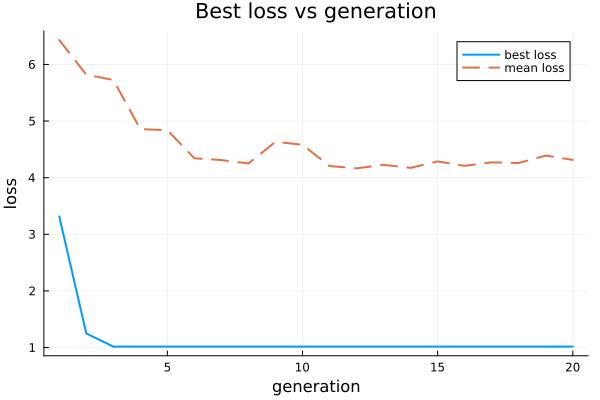

In [228]:
SynthEvo.plot_history(state)

In [200]:
best = argmin(state.fitness)
println("Best loss: ", state.fitness[best])

Best loss: 1.0168702924665054


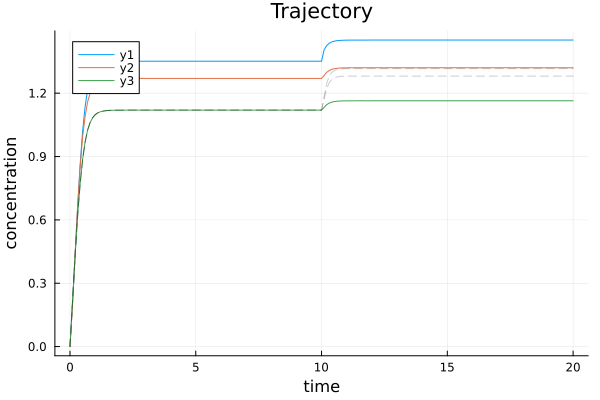

In [229]:
perturb = 2
opt_index = argmin(state.fitness)
#opt_index = 10

SynthEvo.quick_trajectory_plot(C, state.pool[opt_index], 1, [2, 5, 6], t0, t1, 3)

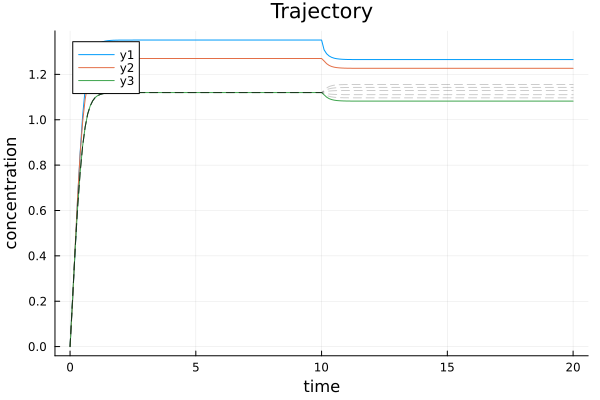

In [202]:
SynthEvo.quick_trajectory_plot(C, state.pool[opt_index], 1, vcat(perturbation_list), t0, t1, 3)

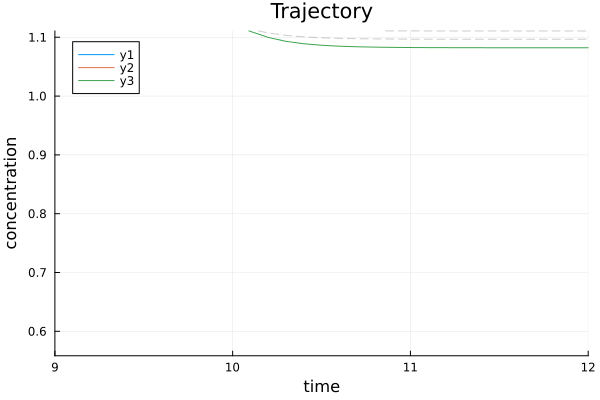

In [203]:
# zoom on reaction 3
SynthEvo.quick_trajectory_plot(C, state.pool[opt_index], 1, vcat(perturbation_list), t0, t1, 3)
xlims!(t0-1., t0+2)
ylims!(sol(t0-1)[3]-sol(t0-1)[3]*0.3, sol(t0+2)[3]+sol(t0+2)[3]*0.3)

In [225]:
SynthEvo.compute_homeostatic_coefficient(C, state.pool[opt_index], 1, 2.5, t0, t1)

  2.086939 seconds (8.10 M allocations: 484.764 MiB, 13.96% gc time)


In [211]:
using Symbolics
using LinearAlgebra
function joint_jacobian(i, j, jac, initial_conditions)
    A_ij = substitute(jac[i, j], initial_conditions)
    return A_ij
end

opt_index = 1
# opt_index = argmin(predictions)
# opt_index = length(loss_tape)

opt_pars_v = state.pool[opt_index]
opt_pars_l = Dict()
for i in 1:length(opt_pars_v)
    opt_pars_l[C.parameters[i]] = opt_pars_v[i]
end


jac = Symbolics.substitute(calculate_jacobian(C.ode), (opt_pars_l))

perturb = 2.5

base_problem = SynthEvo.make_base_problem(C, C.ode, [0 for _ in 1:C.N], [1], state.pool[opt_index], t0, true, 0.1)
shared_solution, solutions = SynthEvo.run_SF_CPU(C, base_problem, t0, t1, [2.5], 1e-5, 1e-5, true, 0.25)
sol = SynthEvo.merge_solutions(shared_solution, solutions, 1, t0)

steady_state_after_perturbation = sol(t1)[1:3]
steady_state_after_perturbation = [
    C.species[1] => steady_state_after_perturbation[1],
    C.species[2] => steady_state_after_perturbation[2],
    C.species[3] => steady_state_after_perturbation[3]
]

A_21 = joint_jacobian(2, 1, jac, steady_state_after_perturbation)
A_32 = joint_jacobian(3, 2, jac, steady_state_after_perturbation)
A_22 = joint_jacobian(2, 2, jac, steady_state_after_perturbation)
A_31 = joint_jacobian(3, 1, jac, steady_state_after_perturbation)

println("A_21 = ", A_21)
println("A_32 = ", A_32)
println("A_22 = ", A_22)
println("A_31 = ", A_31)
println("A_22*A_31 = ", A_22*A_31)
println("A_21*A_32 = ", A_21*A_32)
println("A_22*A_31 - A_21*A_32 = ", A_22*A_31 - A_21*A_32)

A_21 = 6.925536951360516
A_32 = 4.4097979344726195
A_22 = -14.213416062993645
A_31 = 4.051326701468911
A_22*A_31 = -57.583192015093275
A_21*A_32 = 30.540218543223403
A_22*A_31 - A_21*A_32 = -88.12341055831668


In [22]:
using JLD2

save_object("Ultra-Sensitivity.jld2", Dict(
    "state" => state,
    # all parameters 
    "ga_options" => Dict(
        genetic_pool_size => genetic_pool_size,
        elite => elite,
        worst => worst,
        death_rate => death_rate,
        mutation_rate => mutation_rate,
        gradient_mutation_rate => gradient_mutation_rate,
        duplication_rate => duplication_rate,
        crossover_rate => crossover_rate,
        max_generations => max_generations,
        p_cross => p_cross
    ),
    "crn_info" => crn_info,
    "gd_loss_options" => gd_loss_options,
    "gd_options" => gd_options,
    "gd_perturbation_options" => gd_perturbation_options
))    


UndefVarError: UndefVarError: `state` not defined

In [23]:
# test_load = load_object("Ultra-Sensitivity.jld2") 